# Mixed-layer depth

de Boyer Montegut et al., 2004

reference depth

smooth profiles

different criteria
potential temperature exceeds threshold
potential density 

$$ \text{MLD is the depth, where } $$

\begin{equation}
\Delta \theta = \theta_d - \theta_s \gt 0.2 ^{\circ}C
\end{equation}

\begin{equation}
\Delta \sigma_0 = \sigma_{0,d} - \sigma_{0,s} \gt 0.03 \text{ kgm}^{-3}
\end{equation}

exception when mld is not found with both criteria, than it takes the mixed layer depth at the density difference

\begin{equation}
\Delta \theta \text{ and } \Delta \sigma_0
\end{equation}

variable criteria

\begin{eqnarray}
\delta \sigma_0 = \sigma_0(\theta_s - 0.2^{\circ}\text{C}, S_{A,s}, p_s) - \sigma_0(\theta_s, S_{A,s}, p_s) \\
\Delta \sigma_0 = \sigma_{0,d} - \sigma_{0,s} \gt \delta \sigma_0
\end{eqnarray}


In [1]:
%run ../_setup.py

import numpy as np
from netCDF4 import Dataset

# from gsw import mlp

import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
def mixed_layer_depth(z, sig0=False, pt=False, SA=False, CT=False, smooth=False):

    # The reference depth is to avoid large part of the strong diurnal cycle in the top few meters of the ocean. 
    # Dong et al. 2008 suggests that 20 m is a sensible determination of "near surface" in the Southern Ocean.
    ref = 20
    iref, ref_dep = min(enumerate(z), key=lambda x: abs(abs(x[1]) - ref))
#     print('reference depth: %s' %ref_dep)

    # smooth profiles with moving average
    if sig0 is not False:
        if smooth:
            N = 5
            sig0 = np.concatenate([np.mean(sig0[:N - 1]) * np.ones(N - 1, ),
                                   np.convolve(sig0.data, np.ones((N,)) / N, mode='valid')])
            sig0 = np.ma.masked_where(sig0 > 1e36, sig0)

        # near-surface value
        sig0_s = sig0[iref]

    if pt is not False:
        if smooth:
            N = 5
            pt = np.concatenate([np.mean(pt[:N - 1]) * np.ones(N - 1, ),
                                 np.convolve(pt.data, np.ones((N,)) / N, mode='valid')])
            pt = np.ma.masked_where(pt > 1e36, pt)

        # near-surface values
        pt_s = pt[iref]

    # Mixed Layer Depth based on de Boyer Montegut et al. 2004's property difference based criteria
    # MLD in potential density difference, fixed threshold criterion (sig0_d - sig0_s) > 0.03 kg/m^3
    if sig0 is not False and SA is False and CT is False:
        imld = iref + next((i for i in range(len(sig0[iref:]))
                            if sig0[i] - sig0_s > 0.03), np.nan)

    # MLD in potential temperature difference, fixed threshold criterion abs(pt_d - pt_s) > 0.2°C
    if pt is not False:
        imld = iref + next((i for i in range(len(pt[iref:]))
                            if abs(pt[i] - pt_s) > 0.2), np.nan)

    # MLD in potential density and potential temperature difference
    if sig0 is not False and pt is not False:
        imld = iref + next((i for i in range(len(sig0[iref:]))
                            if 0.03 < abs(sig0[i] - sig0_s) < 0.125
                            and 0.2 < abs(pt[i] - pt_s) < 1),
                           next(i for i in range(len(sig0[iref:]))
                                if sig0[i] - sig0_s > 0.03))

    # MLD in potential density with a variable threshold criterion
    if sig0 is not False and SA is not False and CT is not False:
        SA_s = SA[iref]
        CT_s = CT[iref]
        dsig0 = sigma0(SA_s, CT_s - 0.2) - sigma0(SA_s, CT_s)
        imld = iref + next((i for i in range(len(sig0[iref:]))
                            if sig0[i] - sig0_s > dsig0), np.nan)

    return imld, sig0, pt

## Questions
1. Should the reference depth be interpolated to exactly 20m?
2. 

In [3]:
input_file_adcp = os.path.join(datadir, 'processed', 'ss9802', 'netcdf', 'ss9802_adcp_ctd.nc')
input_file_ctd = os.path.join(datadir, 'processed', 'ss9802', 'netcdf', 'ss9802_ctd_gsw.nc')

adcp = Dataset(input_file_adcp)
ctd = Dataset(input_file_ctd)

nst = ctd.dimensions['profile'].size


In [4]:
smooth = True
imld = []
for ist in range(nst):
    
    # read variables
    sig0 = ctd['sigma0'][ist,]
    pt = ctd['pt'][ist,]
    z = ctd['z'][ist,]

    # determine index of mixed layer depth 
    imld_tdd = mixed_layer_depth(z, sig0=sig0, pt=pt, smooth=smooth)[0]
    imld.append(imld_tdd)
    
# construct adcp pressure levels
padcp = np.linspace(np.nanmin(adcp['p'][:]), np.nanmax(adcp['p'][:]), adcp.dimensions['plevel'].size)

# find reference depth
ref = 20
iref, ref_dep = min(enumerate(padcp), key=lambda x: abs(x[1] - ref))
print('ADCP reference depth: %s' %ref_dep)

# find pressure of mixed layer depth
pmld = [ctd['p'][i] for i in imld]
imldadcp = [(np.abs(padcp - p)).argmin() for p in pmld]
# pmldadcp = [padcp[i] for i in imldadcp]


ADCP reference depth: 16.8


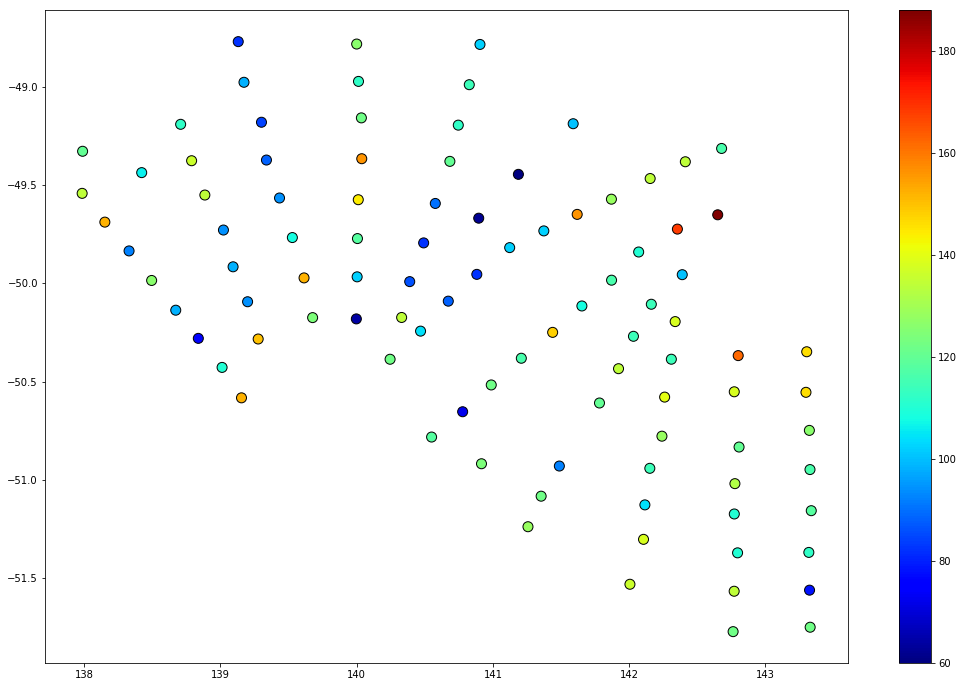

In [8]:
fig, ax = plt.subplots(figsize=(18, 12))
scat = ax.scatter(adcp['lon_ctd'][2:], adcp['lat_ctd'][2:], c=pmld[2:], s=100, cmap=plt.cm.jet, edgecolors='k')
plt.colorbar(scat)

# Layer thickness